In [1]:
%config IPCompleter.use_jedi = False
%pdb off
# %load_ext viztracer
# from viztracer import VizTracer
%load_ext autoreload
%autoreload 3
import sys
from pathlib import Path
import neptune # for logging progress and results
from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import neptune_output_figures
neptune_kwargs = {'project':"commander.pho/PhoDibaLongShort2023",
'api_token':"eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGIxODU2My1lZTNhLTQ2ZWMtOTkzNS02ZTRmNzM5YmNjNjIifQ=="}

# required to enable non-blocking interaction:
%gui qt5

from copy import deepcopy
from numba import jit
import numpy as np
import pandas as pd

# Pho's Formatting Preferences
# from pyphocorehelpers.preferences_helpers import set_pho_preferences, set_pho_preferences_concise, set_pho_preferences_verbose
# set_pho_preferences_concise()

## Pho's Custom Libraries:
from pyphocorehelpers.general_helpers import CodeConversion
from pyphocorehelpers.function_helpers import function_attributes
from pyphocorehelpers.print_helpers import print_keys_if_possible, print_value_overview_only, document_active_variables, objsize, print_object_memory_usage, debug_dump_object_member_shapes, TypePrintMode
from pyphocorehelpers.print_helpers import get_now_day_str, get_now_time_str, get_now_time_precise_str
from pyphocorehelpers.programming_helpers import IPythonHelpers
from pyphocorehelpers.Filesystem.path_helpers import find_first_extant_path

# NeuroPy (Diba Lab Python Repo) Loading
# from neuropy import core
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.core.epoch import NamedTimerange, Epoch
from neuropy.core.ratemap import Ratemap
from neuropy.core.session.Formats.BaseDataSessionFormats import DataSessionFormatRegistryHolder
from neuropy.core.session.Formats.Specific.BapunDataSessionFormat import BapunDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.KDibaOldDataSessionFormat import KDibaOldDataSessionFormatRegisteredClass
from neuropy.core.session.Formats.Specific.RachelDataSessionFormat import RachelDataSessionFormat
from neuropy.core.session.Formats.Specific.HiroDataSessionFormat import HiroDataSessionFormatRegisteredClass

## For computation parameters:
from neuropy.analyses.placefields import PlacefieldComputationParameters
from neuropy.utils.dynamic_container import DynamicContainer
from neuropy.utils.result_context import IdentifyingContext
from neuropy.core.session.Formats.BaseDataSessionFormats import find_local_session_paths
from neuropy.core.neurons import NeuronType


from pyphocorehelpers.print_helpers import generate_html_string


# pyPhoPlaceCellAnalysis:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import NeuropyPipeline # get_neuron_identities
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot, create_daily_programmatic_display_function_testing_folder_if_needed, session_context_to_relative_path
from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import batch_load_session, batch_extended_computations, SessionBatchProgress, batch_programmatic_figures, batch_extended_programmatic_figures
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme
from pyphoplacecellanalysis.Pho2D.matplotlib.visualize_heatmap import visualize_heatmap
from pyphoplacecellanalysis.Pho2D.PyQtPlots.Extensions.pyqtgraph_helpers import build_pyqtgraph_epoch_indicator_regions # Add session indicators to pyqtgraph plot
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import _helper_add_long_short_session_indicator_regions

import pyphoplacecellanalysis.External.pyqtgraph as pg
# 'time_bin_indices': valid_time_bin_indicies, 'posterior_to_pf_mean_surprise': one_left_out_posterior_to_pf_surprises_mean, 'posterior_to_scrambled_pf_mean_surprise': one_left_out_posterior_to_scrambled_pf_surprises_mean}
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import plot_long_short_expected_vs_observed_firing_rates
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import plot_long_short_surprise_difference_plot

from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import _update_pipeline_missing_preprocessing_parameters


session_batch_status = {}
session_batch_errors = {}
enable_saving_to_disk = False

global_data_root_parent_path = find_first_extant_path([Path(r'W:\Data'), Path(r'/media/MAX/Data'), Path(r'/Volumes/MoverNew/data'), Path(r'/home/halechr/turbo/Data')])
assert global_data_root_parent_path.exists(), f"global_data_root_parent_path: {global_data_root_parent_path} does not exist! Is the right computer's config commented out above?"

Automatic pdb calling has been turned OFF
build_module_logger(module_name="Spike3D.pipeline"):
	 Module logger com.PhoHale.Spike3D.pipeline has file logging enabled and will log to EXTERNAL\TESTING\Logging\debug_com.PhoHale.Spike3D.pipeline.log


# Load Pipeline

In [2]:
# ==================================================================================================================== #
# Load Data                                                                                                            #
# ==================================================================================================================== #

active_data_mode_name = 'kdiba'

## Data must be pre-processed using the MATLAB script located here: 
#     neuropy/data_session_pre_processing_scripts/KDIBA/IIDataMat_Export_ToPython_2022_08_01.m
# From pre-computed .mat files:

local_session_root_parent_context = IdentifyingContext(format_name=active_data_mode_name) # , animal_name='', configuration_name='one', session_name=self.session_name
local_session_root_parent_path = global_data_root_parent_path.joinpath('KDIBA')

good_contexts_list = [IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-08_14-26-15'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-09_1-22-43'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='one',session_name='2006-6-12_15-55-31'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-08_21-16-25'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-09_22-24-40'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-12_16-53-46'),
    IdentifyingContext(format_name='kdiba',animal='gor01',exper_name='two',session_name='2006-6-13_15-22-3'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-09_17-29-30'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-17_12-33-47'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-18_13-6-1'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-18_15-23-32'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-19_13-34-40'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='one',session_name='2006-4-27_14-43-12'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-09_16-40-54'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-10_12-58-3'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-11_12-48-38'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-11_16-2-46'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-12_15-25-59'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_14-49-24'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-16_18-47-52'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-17_12-52-15'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-19_13-50-7'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-25_13-20-55'),
    IdentifyingContext(format_name='kdiba',animal='vvp01',exper_name='two',session_name='2006-4-26_13-51-50'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_17-46-44'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-02_19-28-0'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_12-3-25'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-03_21-26-8'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-05_19-26-43'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_21-17-16'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='11-09_22-4-5'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-01_12-58-54'),
    IdentifyingContext(format_name='kdiba',animal='pin01',exper_name='one',session_name='fet11-04_21-20-3')]


In [3]:
%pdb off
# %%viztracer
# [*] - indicates bad or session with a problem
# 0, 1, 2, 3, 4, 5, 6, 7, [8], [9], 10, 11, [12], 13
curr_context = good_contexts_list[0] # select the session from all of the good sessions here.
local_session_parent_path = local_session_root_parent_path.joinpath(curr_context.animal, curr_context.exper_name) # 'gor01', 'one' - probably not needed anymore
basedir = local_session_parent_path.joinpath(curr_context.session_name).resolve()
print(f'basedir: {str(basedir)}')

# # Read if possible:
saving_mode = PipelineSavingScheme.SKIP_SAVING
force_reload = False

# #Force write:
# saving_mode = PipelineSavingScheme.TEMP_THEN_OVERWRITE
# saving_mode = PipelineSavingScheme.OVERWRITE_IN_PLACE 
# force_reload = True

    # ==================================================================================================================== #
    # Load Pipeline                                                                                                        #
    # ==================================================================================================================== #
# with VizTracer(output_file=f"viztracer_{get_now_time_str()}-full_session_LOO_decoding_analysis.json", min_duration=200, tracer_entries=3000000, ignore_frozen=True) as tracer:
# epoch_name_whitelist = ['maze']
epoch_name_whitelist = None
active_computation_functions_name_whitelist=[#'_perform_estimated_epochs_computation', 
                                            '_perform_baseline_placefield_computation',
                                        # '_perform_time_dependent_placefield_computation',
                                        '_perform_extended_statistics_computation',
                                        '_perform_position_decoding_computation', 
                                        '_perform_firing_rate_trends_computation',
                                        '_perform_pf_find_ratemap_peaks_computation',
                                        # '_perform_time_dependent_pf_sequential_surprise_computation'
                                        '_perform_two_step_position_decoding_computation',
                                        # '_perform_recursive_latent_placefield_decoding'
                                    ]
# active_computation_functions_name_whitelist=['_perform_baseline_placefield_computation']

curr_active_pipeline = batch_load_session(global_data_root_parent_path, active_data_mode_name, basedir, epoch_name_whitelist=epoch_name_whitelist,
                                        computation_functions_name_whitelist=active_computation_functions_name_whitelist,
                                        saving_mode=saving_mode, force_reload=force_reload,
                                        skip_extended_batch_computations=True, debug_print=False, fail_on_exception=True) # , active_pickle_filename = 'loadedSessPickle_withParameters.pkl'

if not force_reload: # not just force_reload, needs to recompute whenever the computation fails.
    try:
        curr_active_pipeline.load_pickled_global_computation_results()
    except Exception as e:
        print(f'cannot load global results: {e}')

# 6m 1.1s
# 12m 15.6s


Automatic pdb calling has been turned OFF
basedir: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15
Loading loaded session pickle file results : W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl... done.
Loading pickled pipeline success: W:\Data\KDIBA\gor01\one\2006-6-08_14-26-15\loadedSessPickle.pkl.
property already present in pickled version. No need to save.
using provided computation_functions_name_whitelist: ['_perform_baseline_placefield_computation', '_perform_extended_statistics_computation', '_perform_position_decoding_computation', '_perform_firing_rate_trends_computation', '_perform_pf_find_ratemap_peaks_computation', '_perform_two_step_position_decoding_computation']
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions change. Rework so that this is smarter.
updating computation_results...
done.
	 TODO: this will prevent recomputation even when the blacklist/whitelist or computation function definitions chang

In [4]:
## Post Compute Validate 2023-05-16:
from scripts.run_BatchAnalysis import post_compute_validate

post_compute_validate(curr_active_pipeline)

were pipeline preprocessing parameters missing and updated?: False


In [ ]:
# 2023-01-* - Call extended computations to build `_display_short_long_firing_rate_index_comparison` figures:
extended_computations_include_whitelist=['long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis', 'long_short_decoding_analyses'] # do only specifiedl
# extended_computations_include_whitelist=['long_short_fr_indicies_analyses', 'jonathan_firing_rate_analysis'] # do only specifiedl
newly_computed_values = batch_extended_computations(curr_active_pipeline, include_whitelist=extended_computations_include_whitelist, include_global_functions=True, fail_on_exception=True, progress_print=True, force_recompute=True, debug_print=False)
if len(newly_computed_values) > 0:
	print(f'newly_computed_values: {newly_computed_values}. Saving global results...')
	try:
		# Try to write out the global computation function results:
		curr_active_pipeline.save_global_computation_results()
	except Exception as e:
		print(f'!!WARNING!!: saving the global results threw the exception: {e}')
		print(f'\tthe global results are currently unsaved! proceed with caution and save as soon as you can!')
else:
	print(f'no changes in global results.')
# 10m 29.5s

### Pipeline Loading/Saving

In [ ]:
# Idea: versioning pickles with date?
from datetime import datetime

# datetime object containing current date and time
save_time = datetime.now()
 
print("save_time =", save_time)

# dd/mm/YY H:M:S
dt_string = save_time.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

# save_time = date

#### 2023-05-26 - On only updating/appending the pickle file instead of having to re-write the whole 30GB+ thing
The pickle file format is a sequential format. Thus, if you change one item, at least everything behind that position in the file has to be rewritten.

Also see: https://docs.python.org/3.6/library/shelve.html


In [ ]:
from pyphoplacecellanalysis.General.Pipeline.NeuropyPipeline import PipelineSavingScheme

from pyphocorehelpers.print_helpers import DocumentationFilePrinter, print_filesystem_file_size, print_object_memory_usage, print_keys_if_possible, debug_dump_object_member_shapes


In [ ]:
print_object_memory_usage(curr_active_pipeline)
# print_keys_if_possible("curr_active_pipeline._stage", curr_active_pipeline._stage, max_depth=1, non_expanded_item_keys=['display_output'], additional_excluded_item_classes=['DynamicParameters'])

In [ ]:
doc_printer = DocumentationFilePrinter(doc_output_parent_folder=Path('/home/halechr/repo/Spike3D/EXTERNAL/DEVELOPER_NOTES/DataStructureDocumentation'), doc_name='NeuropyPipeline')
doc_printer.save_documentation('NeuropyPipeline', curr_active_pipeline, non_expanded_item_keys=['stage','_reverse_cellID_index_map', 'pf_listed_colormap', 'computation_results', 'active_configs', 'logger', 'plot', '_plot_object', 'display_output'],
                               additional_excluded_item_classes=["<class 'pyphoplacecellanalysis.General.Pipeline.Stages.Display.Plot'>"], max_depth=16) # 'Logger'



In [ ]:
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE) # AttributeError: 'PfND_TimeDependent' object has no attribute '_included_thresh_neurons_indx'
# TypeError: cannot pickle 'MplMultiTab' object
# PicklingError: Can't pickle .set_closure_cell at 0x000002BF248F50D0>: it's not found as attr._compat.make_set_closure_cell..set_closure_cell
# TypeError: cannot pickle 'PyQt5.QtCore.pyqtSignal' object

In [ ]:
curr_active_pipeline.save_global_computation_results() # PicklingError: Can't pickle .set_closure_cell at 0x000002BF248F50D0>: it's not found as attr._compat.make_set_closure_cell..set_closure_cell

In [ ]:
curr_active_pipeline.load_pickled_global_computation_results()

In [ ]:

curr_active_pipeline.display_output_history_list
curr_active_pipeline.display_output.clear()
# curr_active_pipeline.display_output = DynamicParameters()
# curr_active_pipeline.display_output

In [ ]:
curr_active_pipeline.clear_display_outputs()
curr_active_pipeline.clear_registered_output_files()

In [ ]:
# curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.OVERWRITE_IN_PLACE)
curr_active_pipeline.save_pipeline(saving_mode=PipelineSavingScheme.TEMP_THEN_OVERWRITE)

In [ ]:
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D

# Get existing laps from session:
long_laps, short_laps, global_laps = [curr_active_pipeline.filtered_sessions[an_epoch_name].laps.as_epoch_obj() for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_replays, short_replays, global_replays = [Epoch(curr_active_pipeline.filtered_sessions[an_epoch_name].replay.epochs.get_valid_df()) for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
# short_laps.n_epochs: 40, long_laps.n_epochs: 40
# short_replays.n_epochs: 6, long_replays.n_epochs: 8

print(f'short_laps.n_epochs: {short_laps.n_epochs}, long_laps.n_epochs: {long_laps.n_epochs}')
print(f'short_replays.n_epochs: {short_replays.n_epochs}, long_replays.n_epochs: {long_replays.n_epochs}')

# End Run

In [5]:
## long_short_decoding_analyses:
curr_long_short_decoding_analyses = curr_active_pipeline.global_computation_results.computed_data['long_short_leave_one_out_decoding_analysis']
## Extract variables from results object:
long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus, long_short_pf_neurons_diff, n_neurons, long_results_obj, short_results_obj, is_global = curr_long_short_decoding_analyses.long_decoder, curr_long_short_decoding_analyses.short_decoder, curr_long_short_decoding_analyses.long_replays, curr_long_short_decoding_analyses.short_replays, curr_long_short_decoding_analyses.global_replays, curr_long_short_decoding_analyses.long_shared_aclus_only_decoder, curr_long_short_decoding_analyses.short_shared_aclus_only_decoder, curr_long_short_decoding_analyses.shared_aclus, curr_long_short_decoding_analyses.long_short_pf_neurons_diff, curr_long_short_decoding_analyses.n_neurons, curr_long_short_decoding_analyses.long_results_obj, curr_long_short_decoding_analyses.short_results_obj, curr_long_short_decoding_analyses.is_global

# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D
decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

In [16]:
curr_active_pipeline.reload_default_display_functions()
batch_extended_programmatic_figures(curr_active_pipeline=curr_active_pipeline)
# 


_out = curr_active_pipeline.display('_display_long_short_laps', curr_active_pipeline.sess.get_context())

In [17]:
neptune_output_figures(curr_active_pipeline=curr_active_pipeline)

https://app.neptune.ai/commander.pho/PhoDibaLongShort2023/e/PHOD-248
a_fig_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2023-05-30\kdiba\gor01\one\2006-6-08_14-26-15\kdiba_gor01_one_2006-6-08_14-26-15_maze1__display_1d_placefields.pdf, a_fig_context: kdiba_gor01_one_2006-6-08_14-26-15_maze1__display_1d_placefields
	session/kdiba_gor01_one_2006-6-08_14-26-15_sess/figures/kdiba_gor01_one_2006-6-08_14-26-15_maze1__display_1d_placefields
a_fig_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\ProgrammaticDisplayFunctionTesting\2023-05-30\kdiba\gor01\one\2006-6-08_14-26-15\kdiba_gor01_one_2006-6-08_14-26-15_maze2__display_1d_placefields.pdf, a_fig_context: kdiba_gor01_one_2006-6-08_14-26-15_maze2__display_1d_placefields
	session/kdiba_gor01_one_2006-6-08_14-26-15_sess/figures/kdiba_gor01_one_2006-6-08_14-26-15_maze2__display_1d_placefields
a_fig_path: C:\Users\pho\repos\Spike3DWorkEnv\Spike3D\EXTERNAL\Screenshots\

## 2023-05-26 - Get Expected firing rates

In [30]:
from scipy.special import factorial, logsumexp

def compute_measured_vs_expected_firing_rates(active_pos_df, active_filter_epochs, a_decoder_1D, a_decoder_result):
	""" 2023-05-26 - Goal is to compute the expected and measured firing rates for each cell for each epoch. 

	Want to be able to get a vector of firing rates (one for each cell) for an epoch i.

	"""
	all_cells_decoded_epoch_time_bins = {}
	all_cells_decoded_expected_firing_rates = {}
	# all_cells_observed_firing_rates = {}

	## for each cell:
	for i, left_out_aclu in enumerate(a_decoder_1D.neuron_IDs):
		# aclu = decoder_1D.neuron_IDs[i]
		left_out_neuron_IDX = a_decoder_1D.neuron_IDXs[i] # should just be i, but just to be safe
		## TODO: only look at bins where the cell fires (is_cell_firing_time_bin[i])

		## single cell outputs:
		curr_cell_decoded_epoch_time_bins = [] # will be a list of the time bins in each epoch that correspond to each surprise in the corresponding list in curr_cell_computed_epoch_surprises 
		
		curr_cell_pf_curve = a_decoder_1D.pf.ratemap.tuning_curves[left_out_neuron_IDX]
		# curr_cell_spike_curve = decoder_1D.pf.ratemap.spikes_maps[unit_IDX] ## not occupancy weighted... is this the right one to use for computing the expected spike rate? NO... doesn't seem like it

		## Must pre-allocate each with an empty list:
		all_cells_decoded_expected_firing_rates[left_out_aclu] = [] 
		
		for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs):
			curr_epoch_time_bin_container = a_decoder_result.time_bin_containers[decoded_epoch_idx]
			curr_cell_decoded_epoch_time_bins.append(curr_epoch_time_bin_container)
			curr_time_bins = curr_epoch_time_bin_container.centers
			curr_epoch_p_x_given_n = a_decoder_result.p_x_given_n_list[decoded_epoch_idx] # .shape: (239, 5) - (n_x_bins, n_epoch_time_bins)
			assert curr_epoch_p_x_given_n.shape[0] == curr_cell_pf_curve.shape[0]
			
			## Need to exclude estimates from bins that didn't have any spikes in them (in general these glitch around):
			curr_total_spike_counts_per_window = np.sum(a_decoder_result.spkcount[decoded_epoch_idx], axis=0) # left_out_decoder_result.spkcount[i].shape # (69, 222) - (nCells, nTimeWindowCenters)
			curr_is_time_bin_non_firing = (curr_total_spike_counts_per_window == 0) # this would mean that no cells fired in this time bin
			# curr_non_firing_time_bin_indicies = np.where(curr_is_time_bin_non_firing)[0] # TODO: could also filter on a minimum number of spikes larger than zero (e.g. at least 2 spikes are required).
			# curr_posterior_container = decoder_result.marginal_x_list[decoded_epoch_idx]
			# curr_posterior = curr_posterior_container.p_x_given_n # TODO: check the posteriors too!
			# curr_most_likely_positions = curr_posterior_container.most_likely_positions_1D # (n_epoch_time_bins, ) one position for each time bin in the replay
			curr_most_likely_position_indicies = a_decoder_result.most_likely_position_indicies_list[decoded_epoch_idx] # (n_epoch_time_bins, ) one position for each time bin in the replay
			
			# curr_epoch_observed_num_spikes = decoder_result.spkcount[decoded_epoch_idx] # (nCells, n_epoch_time_bins)
			
			# From the firing map of the placefields for this neuron (`decoder_1D.F.T[left_out_neuron_IDX]`) get the value for each position bin index in the epoch
			curr_epoch_expected_fr = np.squeeze(a_decoder_1D.F.T[left_out_neuron_IDX][curr_most_likely_position_indicies])
			# expected_num_spikes = curr_epoch_expected_fr * decoder_result.decoding_time_bin_size

			# Eqn 1:
			# p_n_given_x = lambda n: (1.0/factorial(n)) * pow(expected_num_spikes, n) * np.exp(-expected_num_spikes) # likelihood function
			
			# Compute the expected firing rate for this cell during each bin by taking the computed position posterior and taking the sum of the element-wise product with the cell's placefield.
			# curr_epoch_expected_fr = decoder_1D.pf.ratemap.tuning_curve_unsmoothed_peak_firing_rates[left_out_neuron_IDX] * np.array([np.sum(curr_cell_pf_curve * curr_p_x_given_n) for curr_p_x_given_n in curr_epoch_p_x_given_n.T]) # * decoder_1D.pf.ratemap.
			
			all_cells_decoded_expected_firing_rates[left_out_aclu].append(curr_epoch_expected_fr)


		## End loop over decoded epochs
		# assert len(curr_cell_decoded_epoch_time_bins) == len(curr_cell_computed_epoch_surprises)
		all_cells_decoded_epoch_time_bins[left_out_aclu] = curr_cell_decoded_epoch_time_bins

	## End loop over cells


	## Reshape to -for-each-epoch instead of -for-each-cell
	all_epochs_decoded_epoch_time_bins = []
	# all_epochs_computed_surprises = []
	all_epochs_computed_expected_cell_firing_rates = []
	# all_epochs_computed_one_left_out_to_global_surprises = []
	for decoded_epoch_idx in np.arange(active_filter_epochs.n_epochs):
		all_epochs_decoded_epoch_time_bins.append(np.array([all_cells_decoded_epoch_time_bins[aclu][decoded_epoch_idx].centers for aclu in a_decoder_1D.neuron_IDs])) # these are duplicated (and the same) for each cell
		# all_epochs_computed_surprises.append(np.array([all_cells_computed_epoch_surprises[aclu][decoded_epoch_idx] for aclu in decoder_1D.neuron_IDs]))
		all_epochs_computed_expected_cell_firing_rates.append(np.array([all_cells_decoded_expected_firing_rates[aclu][decoded_epoch_idx] for aclu in a_decoder_1D.neuron_IDs]))
		# all_epochs_computed_one_left_out_to_global_surprises.append(np.array([all_cells_computed_epoch_one_left_out_to_global_surprises[aclu][decoded_epoch_idx] for aclu in decoder_1D.neuron_IDs]))

	# # assert len(all_epochs_computed_surprises) == active_filter_epochs.n_epochs
	# # assert len(all_epochs_computed_surprises[0]) == decoder_1D.num_neurons
	# flat_all_epochs_decoded_epoch_time_bins = np.hstack(all_epochs_decoded_epoch_time_bins) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
	# # flat_all_epochs_computed_surprises = np.hstack(all_epochs_computed_surprises) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
	# flat_all_epochs_computed_expected_cell_firing_rates = np.hstack(all_epochs_computed_expected_cell_firing_rates) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs
	# # flat_all_epochs_computed_one_left_out_to_global_surprises = np.hstack(all_epochs_computed_one_left_out_to_global_surprises) # .shape (65, 4584) -- (n_neurons, n_epochs * n_timebins_for_epoch_i), combines across all time_bins within all epochs

	## These are already in the -for-each-epoch form and just need conversion:
	decoder_time_bin_centers = [a_decoder_result.time_bin_containers[decoded_epoch_idx].centers for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	all_epochs_computed_expected_cell_num_spikes = [(all_epochs_computed_expected_cell_firing_rates[decoded_epoch_idx] * a_decoder_result.decoding_time_bin_size) for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	all_epochs_computed_observed_from_expected_difference = [(all_epochs_computed_expected_cell_num_spikes[decoded_epoch_idx] - a_decoder_result.spkcount[decoded_epoch_idx]) for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	# Interpolate the measured positions to the window center times:
	measured_pos_window_centers = [np.interp(curr_time_bins, active_pos_df.t, active_pos_df.lin_pos) for curr_time_bins in decoder_time_bin_centers] # TODO 2023-05-26: do I want .x or .lin_pos?
	
	## These aggregate over all time bins in each epoch:
		# Note that some of these correspond to values that are still separate by cell

	all_epochs_decoded_epoch_time_bins_mean = np.vstack([np.mean(curr_epoch_time_bins, axis=1) for curr_epoch_time_bins in all_epochs_decoded_epoch_time_bins]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)
	all_epochs_computed_expected_cell_firing_rates_mean = np.vstack([np.mean(curr_epoch_values, axis=1) for curr_epoch_values in all_epochs_computed_expected_cell_firing_rates]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)
	all_epochs_computed_expected_cell_firing_rates_stddev = np.vstack([np.std(curr_epoch_values, axis=1) for curr_epoch_values in all_epochs_computed_expected_cell_firing_rates]) # mean over all time bins in each epoch  # .shape (614, 65) - (n_epochs, n_neurons)

	# the maximum magnitude difference is found for all timebins within each epoch. This gives 1 value for each epoch
	all_epochs_computed_observed_from_expected_difference_max_index = [np.argmax(np.abs(all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx]), axis=1, keepdims=False) for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	# all_epochs_computed_observed_from_expected_difference_maximum = [all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx][:, all_epochs_computed_observed_from_expected_difference_max_index[decoded_epoch_idx]] for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]

	all_epochs_computed_observed_from_expected_difference_maximum = [np.array([all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx][neuron_IDX, all_epochs_computed_observed_from_expected_difference_max_index[decoded_epoch_idx][neuron_IDX]] for neuron_IDX in np.arange(len(a_decoder_1D.neuron_IDs))]) for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	
	# all_epochs_computed_observed_from_expected_difference_maximum = [all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx][all_epochs_computed_observed_from_expected_difference_max_index[decoded_epoch_idx]] for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]
	# all_epochs_computed_observed_from_expected_difference_maximum = [np.mean(all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx], axis=1) for decoded_epoch_idx in np.arange(a_decoder_result.num_filter_epochs)]

	return decoder_time_bin_centers, all_epochs_computed_expected_cell_num_spikes, all_epochs_computed_observed_from_expected_difference, measured_pos_window_centers, (all_epochs_decoded_epoch_time_bins_mean, all_epochs_computed_expected_cell_firing_rates_mean, all_epochs_computed_expected_cell_firing_rates_stddev, all_epochs_computed_observed_from_expected_difference_maximum)



In [31]:

# long_one_step_decoder_1D, short_one_step_decoder_1D, long_replays, short_replays, global_replays, long_shared_aclus_only_decoder, short_shared_aclus_only_decoder, shared_aclus

active_pos_df = global_session.position.to_dataframe()
assert (long_results_obj.active_filter_epochs.as_array() == short_results_obj.active_filter_epochs.as_array()).all() # ensure that the active_filter_epochs for both are the same.
active_filter_epochs = long_results_obj.active_filter_epochs

## Long Specific:
decoder_1D_LONG = long_results_obj.original_1D_decoder
decoder_result_LONG = long_results_obj.all_included_filter_epochs_decoder_result
# call `compute_measured_vs_expected_firing_rates`
decoder_time_bin_centers_LONG, all_epochs_computed_expected_cell_num_spikes_LONG, all_epochs_computed_observed_from_expected_difference_LONG, measured_pos_window_centers_LONG, (all_epochs_decoded_epoch_time_bins_mean_LONG, all_epochs_computed_expected_cell_firing_rates_mean_LONG, all_epochs_computed_expected_cell_firing_rates_stddev_LONG, all_epochs_computed_observed_from_expected_difference_maximum_LONG) = compute_measured_vs_expected_firing_rates(active_pos_df, active_filter_epochs, decoder_1D_LONG, decoder_result_LONG)
# The Flat_* versions exist because it's difficult to plot while all of the metrics are separated in lists.
Flat_decoder_time_bin_centers_LONG = np.concatenate(decoder_time_bin_centers_LONG) # .shape: (412,)
Flat_all_epochs_computed_expected_cell_num_spikes_LONG = [np.concatenate([all_epochs_computed_observed_from_expected_difference_LONG[decoded_epoch_idx][target_neuron_IDX, :] for decoded_epoch_idx in np.arange(decoder_result_LONG.num_filter_epochs)]) for target_neuron_IDX in decoder_1D_LONG.neuron_IDXs] # a list for each neuron
# Flat_all_epochs_computed_expected_cell_num_spikes

In [32]:
## Short Specific:
decoder_1D_SHORT = short_results_obj.original_1D_decoder
decoder_result_SHORT = short_results_obj.all_included_filter_epochs_decoder_result

# call `compute_measured_vs_expected_firing_rates`
decoder_time_bin_centers_SHORT, all_epochs_computed_expected_cell_num_spikes_SHORT, all_epochs_computed_observed_from_expected_difference_SHORT, measured_pos_window_centers_SHORT, (all_epochs_decoded_epoch_time_bins_mean_SHORT, all_epochs_computed_expected_cell_firing_rates_mean_SHORT, all_epochs_computed_expected_cell_firing_rates_stddev_SHORT, all_epochs_computed_observed_from_expected_difference_maximum_SHORT) = compute_measured_vs_expected_firing_rates(active_pos_df, active_filter_epochs, decoder_1D_SHORT, decoder_result_SHORT)
# The Flat_* versions exist because it's difficult to plot while all of the metrics are separated in lists.
Flat_decoder_time_bin_centers_SHORT = np.concatenate(decoder_time_bin_centers_SHORT) # .shape: (412,)
Flat_all_epochs_computed_expected_cell_num_spikes_SHORT = [np.concatenate([all_epochs_computed_observed_from_expected_difference_SHORT[decoded_epoch_idx][target_neuron_IDX, :] for decoded_epoch_idx in np.arange(decoder_result_SHORT.num_filter_epochs)]) for target_neuron_IDX in decoder_1D_SHORT.neuron_IDXs] # a list for each neuron
Flat_epoch_time_bins_mean = all_epochs_decoded_epoch_time_bins_mean_SHORT[:,0]


In [ ]:
# Sanity Checks that the LONG and SHORT decoders and their decoded results aren't identical:
assert (Flat_decoder_time_bin_centers_SHORT == Flat_decoder_time_bin_centers_LONG).all()
assert (decoder_1D_LONG.neuron_IDs == decoder_1D_SHORT.neuron_IDs).all()
assert not (decoder_1D_LONG.P_x == decoder_1D_SHORT.P_x).all() # the occupancies shouldn't be identical between the two encoders, this might indicate an error
assert not (decoder_1D_LONG.F == decoder_1D_SHORT.F).all() # the placefields shouldn't be identical between the two encoders, this might indicate an error
assert not np.array([(Flat_all_epochs_computed_expected_cell_num_spikes_LONG[i] == Flat_all_epochs_computed_expected_cell_num_spikes_SHORT[i]).all() for i in np.arange(active_filter_epochs.n_epochs)]).all(), "all expected number spikes for all cells should not be the same for two different decoders! This likely indicates an error!"

# 2023-05-26 - MONDAY TODO - Plot the `all_epochs_computed_observed_from_expected_difference_maximum` which should show the change from expectation for each neuron.

In [ ]:
# UNUSED: Test for a single epoch:
decoded_epoch_idx = 2
curr_epoch_observed_num_spikes = decoder_result_LONG.spkcount[decoded_epoch_idx] # (nCells, n_epoch_time_bins)
curr_epoch_observed_num_spikes #.shape: (42, 8)

curr_epoch_expected_num_spikes = all_epochs_computed_expected_cell_num_spikes_LONG[decoded_epoch_idx] # (nCells, n_epoch_time_bins)
curr_epoch_expected_num_spikes.shape # (42, 8)
assert curr_epoch_observed_num_spikes.shape == curr_epoch_expected_num_spikes.shape, f"curr_epoch_observed_num_spikes.shape: {curr_epoch_observed_num_spikes.shape} != curr_epoch_expected_num_spikes.shape: {curr_epoch_expected_num_spikes.shape}"
# all_epochs_computed_expected_cell_firing_rates[decoded_epoch_idx].shape



In [ ]:
decoder_1D_LONG.num_neurons
decoder_1D_LONG.neuron_IDXs
decoder_1D_LONG.neuron_IDs

In [38]:
len(all_epochs_computed_observed_from_expected_difference_maximum_LONG) # len(...): 20 (n_epochs)
all_epochs_computed_observed_from_expected_difference_maximum_LONG[0].shape # [0].shape: (22, ) (n_cells, )

all_epochs_computed_observed_from_expected_difference_maximum_LONG = np.vstack(all_epochs_computed_observed_from_expected_difference_maximum_LONG).T #.shape (20, 22)
# all_epochs_computed_observed_from_expected_difference_maximum_LONG # [1].shape (20,)
all_epochs_computed_observed_from_expected_difference_maximum_SHORT = np.vstack(all_epochs_computed_observed_from_expected_difference_maximum_SHORT).T #.shape (20,	22)

all_epochs_computed_observed_from_expected_difference_maximum_SHORT.shape # [0,:].shape

(30, 120)

In [35]:
t_SHARED = Flat_decoder_time_bin_centers.copy()
y_LONG = Flat_all_epochs_computed_expected_cell_num_spikes_LONG.copy()
y_SHORT = Flat_all_epochs_computed_expected_cell_num_spikes_SHORT.copy()

In [39]:
t_SHARED = Flat_epoch_time_bins_mean.copy()
y_LONG = all_epochs_computed_observed_from_expected_difference_maximum_LONG.copy()
y_SHORT = all_epochs_computed_observed_from_expected_difference_maximum_SHORT.copy()

In [40]:
import matplotlib
from neuropy.utils.matplotlib_helpers import draw_epoch_regions
%matplotlib qt
import matplotlib.pyplot as plt


""" plots one subplot for each neuron. 

t_SHARED, y_LONG, y_SHORT

"""


# the y-min and max across all cells and time bins:
global_y_max_SHORT = np.max([np.max(v) for v in y_SHORT]) # 0.9280231494040394
global_y_min_SHORT = np.min([np.min(v) for v in y_SHORT]) # -4.850176354048617
print(f'global_y_min_SHORT: {global_y_min_SHORT}, global_y_max_SHORT: {global_y_max_SHORT}')

global_y_max_LONG = np.max([np.max(v) for v in y_LONG]) # 0.9280231494040394
global_y_min_LONG = np.min([np.min(v) for v in y_LONG]) # -4.850176354048617
print(f'global_y_min_LONG: {global_y_min_LONG}, global_y_max_LONG: {global_y_max_LONG}')

# the y-min and max across all cells and time bins:
global_y_max = np.max([global_y_max_LONG, global_y_max_SHORT]) # 0.9280231494040394
global_y_min = np.min([global_y_min_LONG, global_y_min_SHORT]) # -4.850176354048617
print(f'global_y_min: {global_y_min}, global_y_max: {global_y_max}')


fig, axes = plt.subplots(ncols=1, nrows=20, sharex=True, sharey=True)

shift_offset = 0
for i, ax in enumerate(axes):
	shifted_i = shift_offset + i
	neuron_IDX = decoder_1D_LONG.neuron_IDXs[shifted_i]
	neuron_id = decoder_1D_LONG.neuron_IDs[shifted_i]
	
	# ax.scatter(Flat_decoder_time_bin_centers, np.concatenate([all_epochs_computed_observed_from_expected_difference[decoded_epoch_idx][neuron_IDX, :] for decoded_epoch_idx in np.arange(decoder_result.num_filter_epochs)]), marker="o",  s=2)
	# ax.scatter(Flat_decoder_time_bin_centers, Flat_all_epochs_computed_expected_cell_num_spikes[neuron_IDX], marker="o",  s=2, label=f'long[{neuron_id}]')
	ax.axhline(y=0.0, linewidth=1, color='k') # the y=0.0 line
	# Per-epoch result:
	# ax.scatter(Flat_decoder_time_bin_centers_LONG, Flat_all_epochs_computed_expected_cell_num_spikes_LONG[neuron_IDX], marker="o",  s=2, label=f'Long[{neuron_id}]')
	# ax.scatter(Flat_decoder_time_bin_centers_SHORT, Flat_all_epochs_computed_expected_cell_num_spikes_SHORT[neuron_IDX], marker="o",  s=2, label=f'Short[{neuron_id}]')

	## Add in the mean epoch difference:
	ax.scatter(t_SHARED, all_epochs_computed_observed_from_expected_difference_maximum_LONG[neuron_IDX, :], marker="s",  s=5, label=f'E<Long[{neuron_id}]>')
	ax.scatter(t_SHARED, all_epochs_computed_observed_from_expected_difference_maximum_SHORT[neuron_IDX, :], marker="s",  s=5, label=f'E<Short[{neuron_id}]>')

	ax.set_ylabel(f'{neuron_id}')
	
	epochs_collection, epoch_labels = draw_epoch_regions(curr_active_pipeline.sess.epochs, ax, defer_render=False, debug_print=False)
	
# Set the x-axis and y-axis limits of the first subplot, which because sharex=True and sharey=True will set the rest of the plots too
axes[0].set_xlim([Flat_decoder_time_bin_centers_LONG[0], Flat_decoder_time_bin_centers_LONG[-1]])
axes[0].set_ylim([global_y_min, global_y_max])

plt.title('Expected vs. Observed Firing Rates (by Replay Epoch)')

plt.show()

global_y_min_SHORT: -5.945819796036196, global_y_max_SHORT: 0.6927410250008998
global_y_min_LONG: -5.790890246716992, global_y_max_LONG: 0.4978661095184945
global_y_min: -5.945819796036196, global_y_max: 0.6927410250008998


In [ ]:
all_epochs_computed_observed_from_expected_difference_LONG[0] #.shape (42, 8)

In [ ]:
all_epochs_computed_observed_from_expected_difference_maximum_LONG[0] # .shape (42, 8)

In [ ]:
all_epochs_computed_expected_cell_firing_rates_mean_LONG[0] # .shape (42,)

In [ ]:
all_epochs_computed_observed_from_expected_difference_LONG[0].shape

# Rate Remapping Investigations

In [ ]:
from neuropy.core.neurons import NeuronType
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import compute_rate_remapping_stats
rate_remapping_df = compute_rate_remapping_stats(curr_active_pipeline.global_computation_results.computed_data.long_short_fr_indicies_analysis, global_session.neurons.aclu_to_neuron_type_map, considerable_remapping_threshold=0.7)
# rate_remapping_df
high_remapping_cells_only = rate_remapping_df[rate_remapping_df['has_considerable_remapping']] 
high_remapping_cells_only

In [ ]:
high_remapping_cells_only.index

In [ ]:
# rate_remapping_df.to_clipboard()
rate_remapping_df

In [ ]:
# Extract rr_* variables from rate_remapping_df
rr_aclus = rate_remapping_df.index.values
rr_laps, rr_replays, rr_skew, rr_neuron_type = [rate_remapping_df[n].values for n in ['laps', 'replays', 'skew', 'neuron_type']]


In [ ]:
# Plot using Paginator:
import matplotlib.pyplot as plt
%matplotlib qt

from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import RateRemappingPaginatedFigureController

## Paginated multi-plot
active_identifying_session_ctx = curr_active_pipeline.sess.get_context()
_out_rr_pagination_controller = RateRemappingPaginatedFigureController.init_from_rr_data(rr_aclus, rr_laps, rr_replays, rr_neuron_type, max_subplots_per_page=20, a_name='TestRateRemappingPaginatedFigureController', active_context=active_identifying_session_ctx)
a_paginator = _out_rr_pagination_controller.plots_data.paginator

# Weird Plotting Stuff

In [ ]:
active_identifying_filtered_session_ctx = global_epoch_context
display_output = curr_active_pipeline.display('_display_spike_rasters_window', active_identifying_filtered_session_ctx, type_of_3d_plotter=None) # , type_of_3d_plotter=None
spike_raster_window = display_output['spike_raster_window']
# Extras:
active_2d_plot = spike_raster_window.spike_raster_plt_2d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
active_3d_plot = spike_raster_window.spike_raster_plt_3d # <pyphoplacecellanalysis.GUI.PyQtPlot.Widgets.SpikeRasterWidgets.Spike2DRaster.Spike2DRaster at 0x196c7244280>
main_graphics_layout_widget = active_2d_plot.ui.main_graphics_layout_widget # GraphicsLayoutWidget
main_plot_widget = active_2d_plot.plots.main_plot_widget # PlotItem
background_static_scroll_plot_widget = active_2d_plot.plots.background_static_scroll_window_plot # PlotItem

# _plot_obj

In [ ]:
from pyphocorehelpers.programming_helpers import IPythonHelpers

long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_dict, y_frs_dict = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
active_context = long_short_fr_indicies_analysis_results['active_context']
# IPythonHelpers.cell_vars(lambda: globals())

In [ ]:
long_short_fr_indicies_df = pd.DataFrame({'aclu': list(x_frs_dict.keys()), 'replay_fr_idx': list(x_frs_dict.values()), 'laps_fr_idx': list(y_frs_dict.values())}) # , columns=['aclu','replay_frs']
long_short_fr_indicies_df.set_index('aclu', inplace=True)
# long_short_fr_indicies_df
# long_short_fr_indicies_df.to_clipboard()
long_short_fr_indicies_df

In [ ]:
long_short_fr_indicies_analysis_results

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_neurons_color_map # for plot_short_v_long_pf1D_comparison

# Get existing long/short decoders from the cell under "# 2023-02-24 Decoders"
long_decoder, short_decoder = deepcopy(long_one_step_decoder_1D), deepcopy(short_one_step_decoder_1D)
assert np.all(long_decoder.xbin == short_decoder.xbin)

## 2023-05-01 - Test my interneuron hypothesis by looking at interneurons across the long/short divide

 1. Interneuron identity should be best determinant of active environment.

 2. Do people know anything about interneurons that activate in a given environment? For example, to interneurons activate alongside pyramidal cells when replaying a given environment?

 3. 


In [ ]:


# 1. Interneuron identity should be best determinant of active environment.

# 2. Do people know anything about interneurons that activate in a given environment? For example, to interneurons activate alongside pyramidal cells when replaying a given environment?

# 3. 
# global_results.pf1D_dt.reset()
# global_results.pf2D_dt.reset()
# global_results.all_attributes

list(curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.keys())

curr_active_pipeline.global_computation_results.computed_data.long_short

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())

In [ ]:
jonathan_firing_rate_analysis_result.rdf.rdf

In [ ]:
jonathan_firing_rate_analysis_result.time_binned_instantaneous_unit_specific_spike_rate.time_bins #.shape

In [ ]:
import matplotlib
%matplotlib qt
import matplotlib.pyplot as plt
instantaneous_fr_df = deepcopy(jonathan_firing_rate_analysis_result.time_binned_instantaneous_unit_specific_spike_rate.instantaneous_unit_specific_spike_rate_values)
instantaneous_fr_df['t'] = jonathan_firing_rate_analysis_result.time_binned_instantaneous_unit_specific_spike_rate.time_bins
instantaneous_fr_df #.plot()

smoothed_instantaneous_fr_df = instantaneous_fr_df.ewm(span=60).mean()

smoothed_instantaneous_fr_df.plot(x='t')
plt.title("Instantaneous Firing Rates")
plt.xlabel('time')
plt.ylabel('Firing Rate (Hz)')

In [ ]:
import matplotlib
%matplotlib qt
import matplotlib.pyplot as plt
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import build_figure_basename_from_display_context
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import _plot_session_long_short_track_firing_rate_figures
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())
long_plots, short_plots = _plot_session_long_short_track_firing_rate_figures(curr_active_pipeline, jonathan_firing_rate_analysis_result, figures_parent_out_path=curr_active_pipeline.get_output_path())

In [ ]:
instantaneous_fr_df.set_index('t').to_clipboard()

In [ ]:
## Require placefield presence on either the long or the short
jonathan_firing_rate_analysis_result.neuron_replay_stats_df = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[np.logical_or(jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_long_pf'], jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_short_pf'])]

In [ ]:
jonathan_firing_rate_analysis_result.neuron_replay_stats_df[np.logical_or(jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_long_pf'], jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_short_pf'])].index.to_numpy()

# 2023-05-19 - Testing S-only emergence, L-only replays in S, peak position remappings 

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import JonathanFiringRateAnalysisResult

jonathan_firing_rate_analysis_result = JonathanFiringRateAnalysisResult(**curr_active_pipeline.global_computation_results.computed_data.jonathan_firing_rate_analysis.to_dict())
neuron_replay_stats_df = jonathan_firing_rate_analysis_result.neuron_replay_stats_df.copy()
neuron_replay_stats_df

In [ ]:

from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import SplitPartitionMembership, SetPartition
## 2023-05-19 - Get S-only pfs
is_S_pf_only = np.logical_and(np.logical_not(neuron_replay_stats_df['has_long_pf']), neuron_replay_stats_df['has_short_pf'])
is_S_only = neuron_replay_stats_df.track_membership == SplitPartitionMembership.RIGHT_ONLY
assert (is_S_pf_only == is_S_only).all()
S_only_aclus = neuron_replay_stats_df.index[is_S_only].to_numpy()
neuron_replay_stats_df[is_S_pf_only]


In [ ]:

## Show L-only pfs stop replaying on S
is_L_pf_only = np.logical_and(np.logical_not(neuron_replay_stats_df['has_short_pf']), neuron_replay_stats_df['has_long_pf'])
is_L_only = neuron_replay_stats_df.track_membership == SplitPartitionMembership.LEFT_ONLY
assert (is_L_pf_only == is_L_only).all()
L_only_aclus = neuron_replay_stats_df.index[is_L_only].to_numpy()
neuron_replay_stats_df[is_L_only]


## For ('kdiba', 'gor01', 'one', '2006-6-09_1-22-43') - Have L-only cells [24, 98] that have ['short_num_replays'] = [8, 7]. We were hoping that there would be few to no replays on the S-track that involved L-only cells.

In [ ]:
## 2023-05-23 - Get Common (SHARED) placefields
## Goal 1: From the cells with the placefields on both tracks, compute the degree to which they remap in position and sort them according to their distance.
is_BOTH_pf_only = np.logical_and(neuron_replay_stats_df['has_short_pf'], neuron_replay_stats_df['has_long_pf']) # (63,)
BOTH_pf_only_aclus = neuron_replay_stats_df.index[is_BOTH_pf_only].to_numpy()

## NOTE: is_BOTH_pf_only is a much more stringent requirement (and a strict subset) than `is_BOTH_only`
is_BOTH_only = neuron_replay_stats_df.track_membership == SplitPartitionMembership.SHARED # (99,)
BOTH_only_aclus = neuron_replay_stats_df.index[is_BOTH_only].to_numpy()
assert BOTH_only_aclus.shape[0] >= BOTH_pf_only_aclus.shape[0]

BOTH_pf_only_df = neuron_replay_stats_df[is_BOTH_pf_only].copy()
BOTH_pf_only_df['long_short_pf_peak_x_displacement'] = BOTH_pf_only_df['long_pf_peak_x'].values - BOTH_pf_only_df['short_pf_peak_x'].values
BOTH_pf_only_df['long_short_pf_peak_x_distance'] = BOTH_pf_only_df['long_short_pf_peak_x_displacement'].abs()
BOTH_pf_only_df.sort_values(by=['long_short_pf_peak_x_distance'], inplace=True, ascending=False)
BOTH_pf_only_df

#TODO 2023-05-23 - Can do more detailed peaks analysis with: long_results.RatemapPeaksAnalysis and short_results.RatemapPeaksAnalysis



In [ ]:
long_results

In [ ]:
""" 24 cells, 133 Epochs, 789 Total Timebins
# Other
	
	- is_non_firing_time_bin: numpy.ndarray - (24, 789)
	- all_epochs_num_epoch_time_bins: numpy.ndarray - (133,)
	
    ## Indexing Helpers:
		- all_epochs_reverse_flat_epoch_indicies_array: numpy.ndarray - (789,)
		- split_by_epoch_reverse_flattened_time_bin_indicies: list - (133,)
    
	- original_1D_decoder: pyphoplacecellanalysis.Analysis.Decoder.reconstruction.BasePositionDecoder
		- pf: neuropy.analyses.placefields.PfND
		- neuron_IDXs: numpy.ndarray - (24,)
		- neuron_IDs: numpy.ndarray - (24,)
		- F: numpy.ndarray - (119, 24)
		- P_x: numpy.ndarray - (119, 1)
        
	- flat_all_epochs_decoded_epoch_time_bins: numpy.ndarray - (24, 789)

# Measured
	- flat_all_epochs_measured_cell_spike_counts: numpy.ndarray - (24, 789)
	- flat_all_epochs_measured_cell_firing_rates: numpy.ndarray - (24, 789)


# Expected
	- flat_all_epochs_computed_expected_cell_firing_rates: numpy.ndarray - (24, 789)
	- flat_all_epochs_difference_from_expected_cell_spike_counts: numpy.ndarray - (24, 789)
	- flat_all_epochs_difference_from_expected_cell_firing_rates: numpy.ndarray - (24, 789)
    
    
    
## Epoch-based
	- all_epochs_decoded_epoch_time_bins_mean: numpy.ndarray - (133, 24)

    
    
    
- flat_all_epochs_measured_cell_firing_rates: numpy.ndarray - .shape: (24, 789) 
- flat_all_epochs_computed_expected_cell_firing_rates: numpy.ndarray - .shape: (24, 789)


"""

In [ ]:
long_results_obj.flat_all_epochs_computed_expected_cell_firing_rates
long_results_obj.flat_all_epochs_measured_cell_firing_rates

# long_results_obj.result_df_grouped


measured_dfs = pd.DataFrame(long_results_obj.flat_all_epochs_measured_cell_firing_rates.T, columns=long_results_obj.original_1D_decoder.neuron_IDs)
expected_dfs = pd.DataFrame(long_results_obj.flat_all_epochs_computed_expected_cell_firing_rates.T, columns=long_results_obj.original_1D_decoder.neuron_IDs)
# pd.DataFrame(np.stack((long_results_obj.flat_all_epochs_measured_cell_firing_rates, long_results_obj.flat_all_epochs_computed_expected_cell_firing_rates)), columns=['measured_fr', 'expected_fr'])
measured_dfs.plot()


In [ ]:
# long_laps

global_session.plot_laps_2d()
# long_session.plot_laps_2d()

In [ ]:
jonathan_firing_rate_analysis_result.neuron_replay_stats_df.to_clipboard()

In [ ]:
from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.MultiContextComputationFunctions.LongShortTrackComputations import compute_evening_morning_parition

difference_sorted_aclus, evening_sorted_aclus, morning_sorted_aclus = compute_evening_morning_parition(neuron_replay_stats_df, debug_print=True)
sorted_neuron_replay_stats_df = neuron_replay_stats_df.reindex(difference_sorted_aclus).copy() # This seems to work to re-sort the dataframe by the sort indicies
sorted_neuron_replay_stats_df

In [ ]:
from pyphocorehelpers.indexing_helpers import partition

# Split the replay stats based on the neuron types:
unique_included_neuron_types, (pyr_neuron_replay_stats_df, contaminated_neuron_replay_stats_df, interneuron_neuron_replay_stats_df) = partition(jonathan_firing_rate_analysis_result.neuron_replay_stats_df, 'neuron_type')
pyr_neuron_replay_stats_df

In [ ]:
from neuropy.core.neurons import NeuronType

%matplotlib qt
# Look at replays during ripples vs. those not during ripples. Also potentially PBEs vs. not PBEs.

# NeuronType.from_any_string_series(['pyr','intr'])
'pyr','cont','intr'

active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
curr_active_pipeline.display('_display_jonathan_interactive_replay_firing_rate_comparison', active_identifying_session_ctx, included_neuron_types=NeuronType.from_any_string_series(['pyr'])) # only the pyramidal neurons

In [ ]:
curr_active_pipeline.reload_default_display_functions()

In [ ]:
curr_active_pipeline.display('_display_jonathan_interactive_replay_firing_rate_comparison', active_identifying_session_ctx, included_neuron_types=NeuronType.from_any_string_series(['intr']), require_placefield=False) # only the pyramidal neurons

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import build_replays_custom_scatter_markers, CustomScatterMarkerMode

_curr_included_aclus = jonathan_firing_rate_analysis_result.neuron_replay_stats_df[np.logical_or(jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_long_pf'], jonathan_firing_rate_analysis_result.neuron_replay_stats_df['has_short_pf'])].index.to_numpy()
_curr_output = curr_active_pipeline.display('_display_batch_pho_jonathan_replay_firing_rate_comparison', active_identifying_session_ctx, included_unit_neuron_IDs=_curr_included_aclus, marker_split_mode=CustomScatterMarkerMode.NoSplit)

## 2023-04-13 - Shuffled Surprise
""" 
Relevant Functions:
`perform_full_session_leave_one_out_decoding_analysis`:
	`perform_leave_one_aclu_out_decoding_analysis`:	from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import perform_leave_one_aclu_out_decoding_analysis
	`_analyze_leave_one_out_decoding_results`: from pyphoplacecellanalysis.General.Pipeline.Stages.ComputationFunctions.DefaultComputationFunctions import _analyze_leave_one_out_decoding_results
"""


In [ ]:
# 2023-04-18 - Refactored into decoder_result
result, result_df, result_df_grouped = long_results_obj.result, long_results_obj.result_df, long_results_obj.result_df_grouped

In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import DiagnosticDistanceMetricFigure

## Render the internactive slider that allows selecting the timebin index to debug
n_timebins = np.sum(long_results_obj.all_epochs_num_epoch_time_bins)
timebinned_neuron_info = long_results_obj.timebinned_neuron_info
result = long_results_obj.new_result
active_fig_obj, update_function = DiagnosticDistanceMetricFigure.build_interactive_diagnostic_distance_metric_figure(long_results_obj, timebinned_neuron_info, result)
active_fig_obj.integer_slider(n_timebins=n_timebins, update_func=update_function)

In [ ]:

# 1. Get set of cells active in a given time bin, for each compute the surprise of its placefield with the leave-one-out decoded posterior.

# 2. From the remainder of cells (those not active), randomly choose one to grab the placefield of and compute the surprise with that and the same posterior.

# Expectation: The cells that are included in the time bin are expected to have a lower surprise (be less correlated with) the posterior.

In [ ]:
win, plots = plot_long_short_surprise_difference_plot(curr_active_pipeline, long_results_obj, short_results_obj, long_epoch_name, short_epoch_name)


In [ ]:
long_results_obj.timebinned_neuron_info.n_timebins # 736
short_results_obj.timebinned_neuron_info.n_timebins

In [ ]:
long_results_obj.flat_all_epochs_measured_cell_firing_rates.shape # (30, 736)
# short_results_obj.flat_all_epochs_measured_cell_firing_rates.shape # (30, 736)



In [ ]:
win, plots_tuple, legend = plot_long_short_expected_vs_observed_firing_rates(long_results_obj, short_results_obj, limit_aclus=list(BOTH_pf_only_df.index[:2].values))
long_epoch_indicator_region_items, short_epoch_indicator_region_items = _helper_add_long_short_session_indicator_regions(win, long_epoch=curr_active_pipeline.filtered_epochs[long_epoch_name], short_epoch=curr_active_pipeline.filtered_epochs[short_epoch_name])

In [ ]:
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import export_pyqtgraph_plot # works pretty well seemingly

export_pyqtgraph_plot(win)
# pg.setConfigOption('leftTitle', 'MathText')
# win.setTitle(r'JSD(p_x_given_n, pf[<font size="4"><b><span style="color:red;">i</span></b></font>]) - JSD(p_x_given_n, pf[<font size="4"><b>j</b></font>]) where <font size="4"><b>j</b></font> non-firing')

# win.setTitle(generate_html_string(f'JSD(p_x_given_n, pf[{i_str}]) - JSD(p_x_given_n, pf[{j_str}]) where {j_str} non-firing', font_size=8))

# r'$\fn{JSD}{\matr{pf}_{i}, \Pr{\vec{x}_{t}|\vec{n}_{t}}} - \fn{JSD}{\matr{pf}_{j}, \Pr{\vec{x}_{t}|\vec{n}_{t}}}$'
# title_str

## Pre 2023-04-13

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt

from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import plot_kourosh_activity_style_figure

from neuropy.core.neurons import NeuronType
# # Include only pyramidal aclus:
# print(f'all shared_aclus: {len(shared_aclus)}\nshared_aclus: {shared_aclus}')
# shared_aclu_neuron_type = long_session.neurons.neuron_type[np.isin(long_session.neurons.neuron_ids, shared_aclus)]
# assert len(shared_aclu_neuron_type) == len(shared_aclus)
# # Find only the aclus that are pyramidal:
# is_shared_aclu_pyramidal = (shared_aclu_neuron_type == NeuronType.PYRAMIDAL)
# pyramidal_only_shared_aclus = shared_aclus[is_shared_aclu_pyramidal]
# print(f'num pyramidal_only_shared_aclus: {len(pyramidal_only_shared_aclus)}\npyramidal_only_shared_aclus: {pyramidal_only_shared_aclus}')


## Drop Pyramidal but don't use only shared aclus:
all_aclus = deepcopy(long_session.neurons.neuron_ids)
neuron_type = long_session.neurons.neuron_type
assert len(neuron_type) == len(all_aclus)
# Find only the aclus that are pyramidal:
is_aclu_pyramidal = (neuron_type == NeuronType.PYRAMIDAL)
pyramidal_only_all_aclus = all_aclus[is_aclu_pyramidal]
print(f'num pyramidal_only_all_aclus: {len(pyramidal_only_all_aclus)}\npyramidal_only_all_aclus: {pyramidal_only_all_aclus}')

is_aclu_interneuron = (neuron_type == NeuronType.INTERNEURONS)
interneuron_only_all_aclus = all_aclus[is_aclu_interneuron]
print(f'num interneuron_only_all_aclus: {len(interneuron_only_all_aclus)}\ninterneurons: {interneuron_only_all_aclus}')

# app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, shared_aclus, epoch_idx=5, callout_epoch_IDXs=[0,1,2,3], skip_rendering_callouts=True)
# app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, pyramidal_only_shared_aclus, epoch_idx=2, callout_epoch_IDXs=[0,4], skip_rendering_callouts=False)
app, win, plots, plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, pyramidal_only_all_aclus, epoch_idx=6, callout_epoch_IDXs=[2,4,6], skip_rendering_callouts=False)

In [ ]:

# Use the Jupyter Index Thing
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import DiagnosticDistanceMetricFigure

## Render the internactive slider that allows selecting the timebin index to debug
n_timebins = np.sum(long_results_obj.all_epochs_num_epoch_time_bins)
timebinned_neuron_info = long_results_obj.timebinned_neuron_info
result = long_results_obj.new_result
active_fig_obj, update_function = DiagnosticDistanceMetricFigure.build_interactive_diagnostic_distance_metric_figure(long_results_obj, timebinned_neuron_info, result)
active_fig_obj.integer_slider(n_timebins=n_timebins, update_func=update_function)

In [ ]:
active_fig_obj.export()

In [ ]:
app, win, self.plots, self.plots_data = plot_kourosh_activity_style_figure(long_results_obj, long_session, pyramidal_only_all_aclus, epoch_idx=11, callout_epoch_IDXs=[0,1,2, 3, 4, 5], skip_rendering_callouts=False)

# 2023-04-13 Show Surprise 

In [ ]:
import pyphoplacecellanalysis.External.pyqtgraph as pg
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.MultiContextComparingDisplayFunctions import plot_long_short, plot_long_short_any_values, plot_long_short_expected_vs_observed_firing_rates, _helper_add_long_short_session_indicator_regions
# plot_long_short(long_results_obj, short_results_obj)

In [ ]:
plot_long_short_any_values(long_results_obj=long_results_obj, short_results_obj=short_results_obj)

In [ ]:
plot_long_short_expected_vs_observed_firing_rates(long_results_obj=long_results_obj, short_results_obj=short_results_obj, limit_aclus=[89]) # 4, 89, 28, 97

In [ ]:
x_fn = lambda a_results_obj: a_results_obj.all_epochs_decoded_epoch_time_bins_mean[:,0]
# y_fn = lambda a_results_obj: a_results_obj.all_epochs_all_cells_one_left_out_posterior_to_scrambled_pf_surprises_mean
y_fn = lambda a_results_obj: a_results_obj.all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean
# y_fn = lambda a_results_obj: a_results_obj.all_epochs_computed_one_left_out_posterior_to_pf_surprises

# (time_bins, neurons), (epochs, neurons), (epochs)
# all_epochs_computed_one_left_out_posterior_to_pf_surprises, all_epochs_computed_cell_one_left_out_posterior_to_pf_surprises_mean, all_epochs_all_cells_one_left_out_posterior_to_pf_surprises_mean
win, plots_tuple, legend = plot_long_short_any_values(long_results_obj, short_results_obj, x=x_fn, y=y_fn, limit_aclus=[20])

# 2023-04-13 - Find Good looking epochs:

In [94]:
import matplotlib.pyplot as plt
%matplotlib qt

from pyphocorehelpers.plotting.figure_management import PhoActiveFigureManager2D
from pyphoplacecellanalysis.GUI.Qt.Mixins.PaginationMixins import PaginatedFigureController
from pyphoplacecellanalysis.Pho2D.stacked_epoch_slices import DecodedEpochSlicesPaginatedFigureController

active_identifying_session_ctx = curr_active_pipeline.sess.get_context()
_out_pagination_controller = DecodedEpochSlicesPaginatedFigureController.init_from_decoder_data(long_results_obj.active_filter_epochs, long_results_obj.all_included_filter_epochs_decoder_result, 
	xbin=long_results_obj.original_1D_decoder.xbin, global_pos_df=global_session.position.df, a_name='TestDecodedEpochSlicesPaginationController', active_context=active_identifying_session_ctx,  max_subplots_per_page=10)
# _out_pagination_controller

active_identifying_ctx_string: "kdiba|gor01|one|2006-6-08_14-26-15|plot_single_epoch_slice|shared|1of12|[0 1 2 3 4 5 6 7 8 9]"


In [39]:
# _out_pagination_controller.params.debug_print = True
_pagination_widget = _out_pagination_controller.ui.mw.ui.paginator_controller_widget
_pagination_widget

In [92]:
epochs_linear_fit_df.plot()

<Axes: >

### Add the radon-transformed linear fits to each epoch to the stacked epoch plots:

In [95]:
assert long_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs == np.shape(epochs_linear_fit_df)[0]

radon_transform_plots = []
_out_pagination_controller.plots_data.radon_transform_line_data = []

for epoch_idx, epoch_vel, epoch_intercept in zip(np.arange(long_results_obj.all_included_filter_epochs_decoder_result.num_filter_epochs), epochs_linear_fit_df['velocity'].values, epochs_linear_fit_df['intercept'].values):
    # build the discrete line over the centered time bins:
    epoch_time_bins = long_results_obj.all_included_filter_epochs_decoder_result.time_bin_containers[epoch_idx].centers
    epoch_time_bins = epoch_time_bins - epoch_time_bins[0] # all values should be relative to the start of the epoch:
    epoch_line_eqn = (epoch_vel * epoch_time_bins) + epoch_intercept
    _out_pagination_controller.plots_data.radon_transform_line_data.append(epoch_line_eqn)

def _callback_update_decoded_single_epoch_slice_plot(curr_ax, params: "VisualizationParameters", plots_data: "RenderPlotsData", plots: "RenderPlots", ui: "PhoUIContainer", i:int, curr_time_bins, *args, **kwargs): # curr_posterior, curr_most_likely_positions, debug_print:bool=False
    """ 2023-05-30 - Based off of `_helper_update_decoded_single_epoch_slice_plot` to enable plotting radon transform lines on paged decoded epochs

    Needs only: curr_time_bins, plots_data, i
    Accesses: plots_data.epoch_slices[i,:], plots_data.global_pos_df, params.variable_name, params.xbin, params.enable_flat_line_drawing
    """
    debug_print = kwargs.pop('debug_print', False)
    if debug_print:
        print(f'_callback_update_decoded_single_epoch_slice_plot(..., i: {i}, curr_time_bins: {curr_time_bins})')
    # plot the radon transform line on the epoch:
    radon_transform_plot = curr_ax.plot(curr_time_bins, plots_data.radon_transform_line_data[i], label=f'computed radon transform', linestyle='dashed', linewidth=3, color='#e5ff00', alpha=0.8, marker='+', markersize=10) # Opaque RED # , linestyle='dashed', linewidth=2, color='#ff0000ff'
    if debug_print:
        print(f'\t success!')
    return params, plots_data, plots, ui


# .params.on_render_page_callbacks: a dict of callbacks to be called when the page changes and needs to be re-rendered
on_render_page_callbacks = _out_pagination_controller.params.get('on_render_page_callbacks', None)
if on_render_page_callbacks is None:
    _out_pagination_controller.params.on_render_page_callbacks = {} # allocate a new list
## add or update this callback:
_out_pagination_controller.params.on_render_page_callbacks['plot_radon_transform_line_data'] = _callback_update_decoded_single_epoch_slice_plot

performing callback with name: plot_radon_transform_line_data
_callback_update_decoded_single_epoch_slice_plot(..., i: 10, curr_time_bins: [182.41705173 182.45005173 182.48305173 182.51605173 182.54905173])
	 success!
performing callback with name: plot_radon_transform_line_data
_callback_update_decoded_single_epoch_slice_plot(..., i: 11, curr_time_bins: [188.81375118 188.84675118 188.87975118 188.91275118 188.94575118
 188.97875118])
	 success!
performing callback with name: plot_radon_transform_line_data
_callback_update_decoded_single_epoch_slice_plot(..., i: 12, curr_time_bins: [192.26354397 192.29654397 192.32954397 192.36254397 192.39554397])
	 success!
performing callback with name: plot_radon_transform_line_data
_callback_update_decoded_single_epoch_slice_plot(..., i: 13, curr_time_bins: [193.66412949 193.69712949 193.73012949 193.76312949 193.79612949
 193.82912949 193.86212949])
	 success!
performing callback with name: plot_radon_transform_line_data
_callback_update_decoded_

[autoreload of pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.DecoderPredictionError failed: Traceback (most recent call last):
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 271, in check
    superreload(m, reload, self.old_objects, self.shell)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 496, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 393, in update_generic
    update(a, b)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 361, in update_class
    update_instances(old, new)
  File "c:\Users\pho\repos\Spike3DWorkEnv\Spike3D\.venv\lib\site-packages\IPython\extensions\autoreload.py", line 319, in update_instances
    object.__setattr__(ref, "__class__",

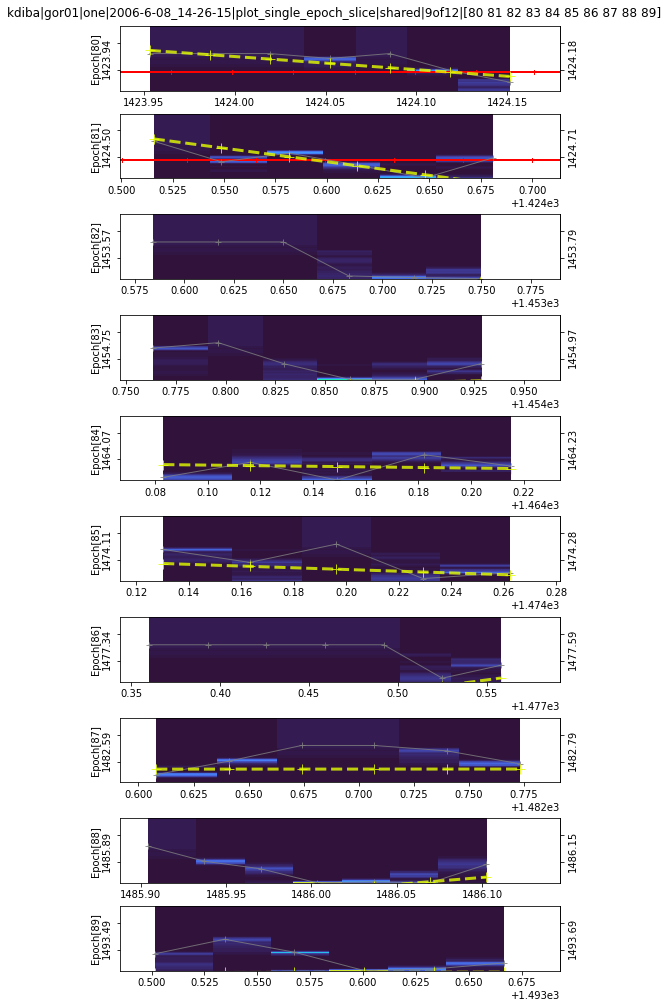

In [96]:
_out_pagination_controller.plots.fig

In [90]:
_out_pagination_controller.ui.mw.draw()

on_selected_epochs_changed(...)
current_page_idx = 0, found_data_index =8
	selection_indicies: [8]
on_selected_epochs_changed(...)
current_page_idx = 0, found_data_index =8
	selection_indicies: []


In [34]:
# .

current_page_idx = _out_pagination_controller.ui.mw.ui.paginator_controller_widget.current_page_idx
curr_page_data_indicies, curr_page_data_items =  _out_pagination_controller.plots_data.paginator.get_page_data(page_idx=current_page_idx)
print(f'current_page_idx: {current_page_idx}, curr_page_data_indicies: {curr_page_data_indicies}')


current_page_idx: 2, curr_page_data_indicies: [20 21 22 23 24 25 26 27 28 29]


In [ ]:
_out_pagination_controller.on_paginator_control_widget_jump_to_page(3)


In [ ]:
from pyphocorehelpers.indexing_helpers import safe_find_index_in_list

def _get_current_page_data_indicies():
	""" captures `ui.mw.ui.paginator_controller_widget.current_page_idx`, `plots_data.paginator` """
	current_page_idx = _out_pagination_controller.ui.mw.ui.paginator_controller_widget.current_page_idx
	curr_page_data_indicies, curr_page_data_items =  _out_pagination_controller.plots_data.paginator.get_page_data(page_idx=current_page_idx)
	return current_page_idx, curr_page_data_indicies

In [ ]:
posterior_containers = filter_epochs_decoder_result.marginal_x_list.copy()

[a_marginal_x_list.p_x_given_n for a_marginal_x_list in filter_epochs_decoder_result.marginal_x_list]
[a_marginal_x_list.most_likely_positions_1D for a_marginal_x_list in filter_epochs_decoder_result.marginal_x_list]

posterior_containers
# posterior_containers = np.array(filter_epochs_decoder_result.marginal_x_list.copy())

In [ ]:
included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers, curr_page_posterior_containers) = epoch_slices_paginator.get_page_data(page_idx=1)
# included_page_data_indicies, (curr_page_active_filter_epochs, curr_page_epoch_labels, curr_page_time_bin_containers) = epoch_slices_paginator.get_page_data(page_idx=1)
included_page_data_indicies
curr_page_posterior_containers[0].p_x_given_n


In [ ]:
from pyphoplacecellanalysis.Analysis.Decoder.reconstruction import DecodedFilterEpochsResult
from pyphocorehelpers.indexing_helpers import safe_len

# {k:safe_len(v) for k,v in filter_epochs_decoder_result.__dict__.items() if (safe_len(v) or 0) > 0}

## Only get the items that are num_filter_epochs long:
epoch_splittable_items = {k:v for k,v in filter_epochs_decoder_result.__dict__.items() if (safe_len(v) or 0) == filter_epochs_decoder_result.num_filter_epochs}
# epoch_splittable_items
epoch_splittable_item_names = list(epoch_splittable_items.keys())
# print(epoch_splittable_item_names)
# ('most_likely_positions_list', 'p_x_given_n_list', 'marginal_x_list', 'marginal_y_list', 'most_likely_position_indicies_list', 'spkcount', 'nbins', 'time_bin_containers', 'time_bin_edges')
# epoch_splittable_item_values = [epoch_splittable_items[k] for k in ('most_likely_positions_list', 'p_x_given_n_list', 'marginal_x_list', 'marginal_y_list', 'most_likely_position_indicies_list', 'nbins', 'time_bin_containers', 'time_bin_edges')]
epoch_splittable_item_values = [epoch_splittable_items[k] for k in ('epoch_description_list','time_bin_containers','marginal_x_list')]
# epoch_splittable_item_values

In [ ]:
# [23, 27, 29, ]
[16, 17, 18, 20, 21, 22, 23, 25, 26, 29]


# 2023-03-28 - Playing around with older computations/visualizations from the `_display_short_long_firing_rate_index_comparison` era:

# Plot long|short firing rate index using 'long_short_fr_indicies_analyses':

In [ ]:
# fig_save_parent_path = Path(r'E:\Dropbox (Personal)\Active\Kamran Diba Lab\Results from 2023-01-20 - LongShort Firing Rate Indicies')
## Get the output path (active_session_figures_out_path) for this session (and all of its filtered_contexts as well):
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
figures_parent_out_path = create_daily_programmatic_display_function_testing_folder_if_needed()
active_session_figures_out_path = session_context_to_relative_path(figures_parent_out_path, active_identifying_session_ctx)
print(f'curr_session_parent_out_path: {active_session_figures_out_path}')
active_session_figures_out_path.mkdir(parents=True, exist_ok=True) # make folder if needed
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', curr_active_pipeline.sess.get_context(), fig_save_parent_path=active_session_figures_out_path)
# plt.close() # closes the current figure

In [ ]:
curr_active_pipeline.display('_display_short_long_firing_rate_index_comparison', long_short_fr_indicies_analysis_results['active_context'], fig_save_parent_path=None)


In [ ]:
import matplotlib
# configure backend here
# matplotlib.use('Qt5Agg')
# backend_qt5agg
matplotlib.use('Qt5Agg') # non-interactive backend ## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
from pyphoplacecellanalysis.General.Pipeline.Stages.DisplayFunctions.MultiContextComparingDisplayFunctions.LongShortTrackComparingDisplayFunctions import _plot_long_short_firing_rate_indicies


# Plot long|short firing rate index:
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_dict, y_frs_dict = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
active_context = long_short_fr_indicies_analysis_results['active_context']
fig, _temp_full_fig_save_path = _plot_long_short_firing_rate_indicies(x_frs_dict, y_frs_dict, active_context, fig_save_parent_path=None, debug_print=False)
fig.show()

In [ ]:
ax = plt.gca()


In [ ]:
ax.spines[['top', 'right']].set_visible(True)

In [ ]:
# curr_active_pipeline.perform_specific_computation(computation_functions_name_whitelist=['_perform_long_short_firing_rate_analyses'], fail_on_exception=True, debug_print=False) # fail_on_exception MUST be True or error handling is all messed up 
long_short_fr_indicies_analysis_results = curr_active_pipeline.global_computation_results.computed_data['long_short_fr_indicies_analysis']
x_frs_dict, y_frs_dict = long_short_fr_indicies_analysis_results['x_frs_index'], long_short_fr_indicies_analysis_results['y_frs_index'] # use the all_results_dict as the computed data value
active_context = long_short_fr_indicies_analysis_results['active_context']
long_short_fr_indicies_analysis_results

# Other Programmatic Figures

### 2023-05-25 - Neptune Figure Uploads from `registered_output_files`


In [ ]:
from pyphoplacecellanalysis.General.Batch.NonInteractiveWrapper import neptune_output_figures

# curr_active_pipeline.registered_output_files
# curr_active_pipeline.register_output_file(output_path=test_path, output_metadata={})

neptune_output_figures(curr_active_pipeline)

In [ ]:
curr_active_pipeline.registered_output_files
# curr_active_pipeline.registered_output_files_list

In [ ]:
import matplotlib as mpl
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import create_daily_programmatic_display_function_testing_folder_if_needed, session_context_to_relative_path, programmatic_display_to_PDF
from pyphoplacecellanalysis.General.Mixins.ExportHelpers import build_pdf_metadata_from_display_context # newer version of build_pdf_export_metadata
from neuropy.core.neuron_identities import PlotStringBrevityModeEnum
from neuropy.plotting.ratemaps import BackgroundRenderingOptions
_bak_rcParams = mpl.rcParams.copy()
mpl.rcParams['toolbar'] = 'None' # disable toolbars
matplotlib.use('AGG') # non-interactive backend ## 2022-08-16 - Surprisingly this works to make the matplotlib figures render only to .png file, not appear on the screen!
# active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_1d_placefields', debug_print=False) # 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_1d_placefield_validations') # , filter_name=active_config_name 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear. Moderate visual improvements can still be made (titles overlap and stuff). Works with %%capture
# programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_result_plot_ratemaps_2D') #  🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.
programmatic_display_to_PDF(curr_active_pipeline, curr_display_function_name='_display_2d_placefield_occupancy') #  🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.


In [ ]:
curr_active_pipeline.reload_default_display_functions()
active_identifying_session_ctx, active_session_figures_out_path, active_out_figures_list = batch_programmatic_figures(curr_active_pipeline)
batch_extended_programmatic_figures(curr_active_pipeline=curr_active_pipeline)

In [ ]:
# plot_helper = curr_active_pipeline.plot
curr_active_pipeline.registered_display_function_docs_dict

In [ ]:
curr_active_pipeline.display_output_history_list

In [ ]:
curr_active_pipeline.display_output

In [ ]:

# '_display_2d_placefield_result_plot_ratemaps_2D'
# %matplotlib inline
%matplotlib qt
# curr_active_pipeline.display('_display_2d_placefield_result_plot_ratemaps_2D', long_epoch_context) # MatplotlibRenderPlots


In [ ]:

# long_pf2D.plot_occupancy()
_out = short_one_step_decoder_2D.pf.plot_ratemaps_2D(included_unit_neuron_IDs=[2,4,5], bg_rendering_mode=BackgroundRenderingOptions.EMPTY, use_special_overlayed_title=False, missing_aclu_string_formatter=None, debug_print=False, brev_mode=PlotStringBrevityModeEnum.NONE)

## Single column output: subplots=(None, 9)


In [ ]:
# %%capture
active_display_to_pdf_fn(curr_active_pipeline, curr_display_function_name='_display_1d_placefields', debug_print=False) # 🟢✅ Now seems to be working and saving to PDF!! Still using matplotlib.use('Qt5Agg') mode and plots still appear.

In [ ]:
long_shared_aclus_only_decoder.pf.plot_occupancy()

In [ ]:
%matplotlib qt
long_one_step_decoder_2D.pf.plot_occupancy()

In [ ]:
long_one_step_decoder_2D.pf.plot_ratemaps_2D()

In [ ]:
# curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_session_configuration_context=global_epoch_context, single_figure=False)

short_one_step_decoder_1D

In [ ]:
%matplotlib qt
active_identifying_session_ctx = curr_active_pipeline.sess.get_context() # 'bapun_RatN_Day4_2019-10-15_11-30-06'

long_single_cell_pfmap_processing_fn = None
short_single_cell_pfmap_processing_fn = None
sort_idx = None

out = curr_active_pipeline.display('_display_short_long_pf1D_comparison', active_identifying_session_ctx, single_figure=False, debug_print=False, fignum='Short v Long pf1D Comparison',
                                   long_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': long_single_cell_pfmap_processing_fn},
                                   short_kwargs={'sortby': sort_idx, 'single_cell_pfmap_processing_fn': short_single_cell_pfmap_processing_fn, 'curve_hatch_style': {'hatch':'///', 'edgecolor':'k'}},
                                  )

# ax = out.axes[0]

In [ ]:
sort_idx = np.argsort(product_overlap_scalars_df.prod_overlap.to_numpy())[::-1] # the `[::-1]` term reverses the array, which by defaul is returned in ascending order and we want descending
sort_idx

In [ ]:
curr_ratemap = long_one_step_decoder_1D.pf.ratemap
curr_ratemap.get_sort_indicies()
# .pf1D.ratemap

In [ ]:
# Create `master_dock_win` - centralized plot output window to collect individual figures/controls in (2022-08-18)

active_identifying_session_ctx = curr_active_pipeline.filtered_contexts['maze']
display_output = curr_active_pipeline.display('_display_context_nested_docks', active_identifying_session_ctx, enable_gui=False, debug_print=True) # returns {'master_dock_win': master_dock_win, 'app': app, 'out_items': out_items}
master_dock_win = display_output['master_dock_win']
app = display_output['app']
out_items = display_output['out_items']

# def _get_curr_figure_format_config():
# 	""" Aims to fetch the current figure_format_config and context from the figure_format_config widget:    
# 	Implicitly captures: `out_items`, `active_config_name`, `active_identifying_filtered_session_ctx` 
# 	"""
# 	## Get the figure_format_config from the figure_format_config widget:
# 	# Fetch the context from the GUI:
# 	_curr_gui_session_ctx, _curr_gui_out_display_items = out_items[active_config_name]
# 	_curr_gui_figure_format_config_widget = _curr_gui_out_display_items[active_identifying_filtered_session_ctx.adding_context('display_fn', display_fn_name='figure_format_config_widget')] # [0] is seemingly not needed to unpack the tuple
# 	if _curr_gui_figure_format_config_widget is not None:
# 		# has GUI for config
# 		figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config
# 	else:
# 		# has non-GUI provider of figure_format_config
# 		figure_format_config = _curr_gui_figure_format_config_widget.figure_format_config

# 	if debug_print:
# 		print(f'recovered gui figure_format_config: {figure_format_config}')

# 	return figure_format_config

# figure_format_config = _get_curr_figure_format_config()

# 2023-04-27 - Idea: Candidate Replay "Quality" Metric
Observed that I visually distinguish "good" replays from bad ones based on their mostly-monotonically increasing nature.

#### They don't have to:
	Span the whole track
	Start or end at an end-cap
	Increase linearly

#### The algorithm must:
	tolerate ocasional jumps in an otherwise linear sequence
	allow sequences to "start" only halfway through. They should extract out the coherent sequence

#### Ideas:
	- just a linear fit
	- a monotonicity check using some sort of cumulative sum over the differences in position.
	- "radon transform"?

# 20230-05-25 - Radon Transform approach to finding line of best fit for each replay Epoch

In [29]:
from pyphoplacecellanalysis.Analysis.Decoder.decoder_result import get_radon_transform

## 2023-05-25 - Get the 1D Posteriors for each replay epoch so they can be analyzed via score_posterior(...) with a Radon Transform approch to find the line of best fit (which gives the velocity).
active_epoch_decoder_result = long_results_obj.all_included_filter_epochs_decoder_result
# active_time_bins = active_epoch_decoder_result.time_bin_edges[0]
# active_posterior_container = active_epoch_decoder_result.marginal_x_list[0]
# active_posterior = active_posterior_container.p_x_given_n
active_posterior = active_epoch_decoder_result.p_x_given_n_list # one for each epoch
# active_most_likely_positions = active_posterior_container.most_likely_positions_1D

# the size of the x_bin in [cm]
pos_bin_size = float(long_results_obj.original_1D_decoder.pf.bin_info['xstep'])

## compute the Radon transform to get the lines of best fit
score, velocity, intercept = get_radon_transform(active_posterior, decoding_time_bin_duration=active_epoch_decoder_result.decoding_time_bin_size, pos_bin_size=pos_bin_size,
                                                  nlines=5000, margin=16, jump_stat=None, posteriors=None, n_jobs=1)

epochs_linear_fit_df = pd.DataFrame({'score': score, 'velocity': velocity, 'intercept': intercept})
epochs_linear_fit_df

,score,velocity,intercept
0,0.584336,216.420765,47.189349
1,0.670000,-20.478029,72.819102
2,0.450712,240.112899,17.224481
3,0.494904,-409.451663,95.790755
4,0.570902,193.202932,60.684810
...,...,...,...
115,0.425862,-839.827819,197.836440
116,0.472130,26.987992,76.647602
117,0.434459,-108.010689,106.292056
118,0.709752,-73.568299,100.672505


In [ ]:
# epochs_linear_fit_df.plot()
## Add the radon-transformed linear fits to each epoch to the stacked epoch plots:
# epochs_linear_fit_df
epochs_linear_fit_df

# 2023-05-02 - Session Validation Check Info
Generate info about the number of laps detected, the duration, the number of cells, the number of replays, etc for the active session so that it can be ensured that there wasn't an error that is messing up the analysis.

In [ ]:
curr_active_pipeline.active_sess_config

# Pipeline Comprehensive:


In [ ]:
## Top level objects:
curr_active_pipeline.active_sess_config
curr_active_pipeline.sess



# Function of config names or contexts:
curr_active_pipeline.filtered_contexts

curr_active_pipeline.filtered_sessions
curr_active_pipeline.active_configs # each is a `InteractivePlaceCellConfig` type object
	curr_active_pipeline._stage.active_configs['maze1']



curr_active_pipeline.computation_results


curr_active_pipeline.global_computation_results



In [ ]:
sess = curr_active_pipeline.sess
sess.config

In [ ]:
from neuropy.core.epoch import EpochsAccessor, Epoch

sess = curr_active_pipeline.sess
# sess.replay.epochs.debug_print_info('replays')


def debug_print_session_epochs_info(sess, session_name:str):
	""" 

	Example:
		debug_print_session_epochs_info(curr_active_pipeline.sess, 'sess')
		debug_print_session_epochs_info(long_session, 'long_session')
		debug_print_session_epochs_info(short_session, 'short_session')
		debug_print_session_epochs_info(global_session, 'global_session')

	sess:
		num replays: 1729
		num laps: 80
	long_session:
		num replays: 661
		num laps: 40
	short_session:
		num replays: 1068
		num laps: 40
	global_session:
		num replays: 1729
		num laps: 80
		
	
	"""	

	replays_df = sess.replay
	laps_df = sess.laps.as_epoch_obj().to_dataframe()
	print(f'{session_name}:')
	print(f'\tnum replays: {replays_df.epochs.n_epochs}')
	print(f'\tnum laps: {laps_df.epochs.n_epochs}')

# (long_one_step_decoder_1D, short_one_step_decoder_1D), (long_one_step_decoder_2D, short_one_step_decoder_2D) = compute_short_long_constrained_decoders(curr_active_pipeline, recalculate_anyway=True)
long_epoch_name, short_epoch_name, global_epoch_name = curr_active_pipeline.find_LongShortGlobal_epoch_names()
long_epoch_context, short_epoch_context, global_epoch_context = [curr_active_pipeline.filtered_contexts[a_name] for a_name in (long_epoch_name, short_epoch_name, global_epoch_name)]
long_session, short_session, global_session = [curr_active_pipeline.filtered_sessions[an_epoch_name] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
# long_results, short_results, global_results = [curr_active_pipeline.computation_results[an_epoch_name]['computed_data'] for an_epoch_name in [long_epoch_name, short_epoch_name, global_epoch_name]]
# long_pf1D, short_pf1D, global_pf1D = long_results.pf1D, short_results.pf1D, global_results.pf1D
# long_pf2D, short_pf2D, global_pf2D = long_results.pf2D, short_results.pf2D, global_results.pf2D
# decoding_time_bin_size = long_one_step_decoder_1D.time_bin_size # 1.0/30.0 # 0.03333333333333333

debug_print_session_epochs_info(curr_active_pipeline.sess, 'sess')
debug_print_session_epochs_info(long_session, 'long_session')
debug_print_session_epochs_info(short_session, 'short_session')
debug_print_session_epochs_info(global_session, 'global_session')


# epoch_df = sess.laps.to_dataframe()

# epoch_df.epochs.n_epochs

# epoch_name = 'laps'
# num_epochs = epoch_df.epochs.n_epochs # np.shape(epoch_df)[0]
# print(f'num {epoch_name}: {num_epochs}')

# sess.replay.to_dataframe()

# def debug_print_session_epochs_info(num_updated_total_items: int, num_original_total_items: int, item_label=None, subsession_name=None):
#     print('{}/{} total {} remain in subsession {}'.format(num_updated_total_items, num_original_total_items, (item_label or "items"), (subsession_name or "")))

# debug_print_subsession_epochs_differences(num_updated_total_items=len(long_session.replay), num_original_total_items=len(long_session.replay_backup), item_label='replays', subsession_name='"long"')
# debug_print_subsession_epochs_differences(num_updated_total_items=len(short_session.replay), num_original_total_items=len(short_session.replay_backup), item_label='replays', subsession_name='"short"')

(long_epoch_name, short_epoch_name, global_epoch_name)

In [ ]:
## BUG 2023-05-25 - Found ERROR for a loaded pipeline where for some reason the filtered_contexts[long_epoch_name]'s actual context was the same as the short maze ('...maze2'). Unsure how this happened.
ctx = curr_active_pipeline.filtered_contexts[long_epoch_name]
ctx.filter_name = long_epoch_name
assert ctx.filter_name == long_epoch_name, f"ctx.filter_name: {ctx.filter_name} != long_epoch_name: {long_epoch_name}"

In [ ]:
list(curr_active_pipeline.active_configs.keys())
list(curr_active_pipeline.filtered_sessions.keys())
list(curr_active_pipeline.filtered_contexts.keys())
# curr_active_pipeline.filtered_sessions
curr_active_pipeline.filtered_contexts

In [ ]:

def debug_print_subsession_epochs_differences(num_updated_total_items: int, num_original_total_items: int, item_label=None, subsession_name=None):
    print('{}/{} total {} remain in subsession {}'.format(num_updated_total_items, num_original_total_items, (item_label or "items"), (subsession_name or "")))

debug_print_subsession_epochs_differences(num_updated_total_items=len(long_session.replay), num_original_total_items=len(long_session.replay_backup), item_label='replays', subsession_name='"long"')
debug_print_subsession_epochs_differences(num_updated_total_items=len(short_session.replay), num_original_total_items=len(short_session.replay_backup), item_label='replays', subsession_name='"short"')


In [ ]:
debug_print_subsession_epochs_differences(num_updated_total_items=len(long_session.laps), num_original_total_items=len(long_session.replay_backup), item_label='laps', subsession_name='"long"')
debug_print_subsession_epochs_differences(num_updated_total_items=len(short_session.laps), num_original_total_items=len(short_session.replay_backup), item_label='laps', subsession_name='"short"')


In [ ]:
before_num_rows = self.n_epochs        
filtered_epochs = convert_PortionInterval_to_epochs_df(_convert_start_end_tuples_list_to_PortionInterval(zip(self.starts, self.stops)))
after_num_rows = np.shape(filtered_epochs)[0]
changed_num_rows = after_num_rows - before_num_rows
print(f'Dataframe Changed from {before_num_rows} -> {after_num_rows} ({changed_num_rows = })')

In [ ]:
from neuropy.utils.debug_helpers import debug_print_placefield, debug_print_spike_counts, debug_print_subsession_neuron_differences, print_aligned_columns
from neuropy.utils.misc import print_seconds_human_readable

debug_print_spike_counts(global_session)

In [ ]:
from pyphoplacecellanalysis.General.Mixins.CrossComputationComparisonHelpers import _compare_computation_results
# curr_active_pipeline.computation_results
# pf_neurons_diff = _compare_computation_results(curr_active_pipeline.computation_results.maze1_PYR, curr_active_pipeline.computation_results.maze2_PYR)
pf_neurons_diff = _compare_computation_results(long_results, short_results)
pf_neurons_diff

In [ ]:
print(pf_neurons_diff)

### Plotting Validations

In [ ]:
%matplotlib qt
short_one_step_decoder_1D.pf.plot_ratemaps_1D()

In [ ]:
short_results.pf1D_Decoder.pf.plot_ratemaps_1D()

In [ ]:
short_results.pf2D_Decoder.pf.plot_ratemaps_2D()
short_one_step_decoder_2D.pf.plot_ratemaps_2D()

In [ ]:
%matplotlib qt
long_session.plot_laps_2d()

In [ ]:
from pyphoplacecellanalysis.PhoPositionalData.plotting.laps import plot_laps_2d

%matplotlib qt
fig, out_axes_list = plot_laps_2d(global_session, legacy_plotting_mode=False)
out_axes_list[0].set_title('New Pho Position Thresholding Estimated Laps')
fig.canvas.manager.set_window_title('New Pho Position Thresholding Estimated Laps')

In [ ]:
## Laps 
from pyphoplacecellanalysis.GUI.PyVista.InteractivePlotter.Mixins.LapsVisualizationMixin import LapsVisualizationMixin

curr_position_df, lap_specific_position_dfs = LapsVisualizationMixin._compute_laps_specific_position_dfs(curr_active_pipeline.sess)
lap_specific_position_dfs = [curr_position_df.groupby('lap').get_group(i)[['t','x','y','lin_pos']] for i in curr_active_pipeline.sess.laps.lap_id] # dataframes split for each ID:
laps_position_times_list = [np.squeeze(lap_pos_df[['t']].to_numpy()) for lap_pos_df in lap_specific_position_dfs]
laps_position_traces_list = [lap_pos_df[['x','y']].to_numpy().T for lap_pos_df in lap_specific_position_dfs]
## Build Epochs:
epochs = curr_active_pipeline.sess.laps.to_dataframe()
epoch_slices = epochs[['start', 'stop']].to_numpy()
epoch_description_list = [f'lap {epoch_tuple.lap_id} (maze: {epoch_tuple.maze_id}, direction: {epoch_tuple.lap_dir})' for epoch_tuple in epochs[['lap_id','maze_id','lap_dir']].itertuples()]
# print(f'epoch_description_list: {epoch_description_list}') # epoch_descriptions: ['lap 41 (maze: 2, direction: 1)', 'lap 42 (maze: 2, direction: 0)', 'lap 43 (maze: 2, direction: 1)', 'lap 44 (maze: 2, direction: 0)', 'lap 45 (maze: 2, direction: 1)', 'lap 46 (maze: 2, direction: 0)', 'lap 47 (maze: 2, direction: 1)', 'lap 48 (maze: 2, direction: 0)', 'lap 49 (maze: 2, direction: 1)', 'lap 50 (maze: 2, direction: 0)', 'lap 51 (maze: 2, direction: 1)', 'lap 52 (maze: 2, direction: 0)', 'lap 53 (maze: 2, direction: 1)', 'lap 54 (maze: 2, direction: 0)', 'lap 55 (maze: 2, direction: 1)', 'lap 56 (maze: 2, direction: 0)', 'lap 57 (maze: 2, direction: 1)', 'lap 58 (maze: 2, direction: 0)', 'lap 59 (maze: 2, direction: 1)', 'lap 60 (maze: 2, direction: 0)', 'lap 61 (maze: 2, direction: 1)', 'lap 62 (maze: 2, direction: 0)', 'lap 63 (maze: 2, direction: 1)', 'lap 64 (maze: 2, direction: 0)', 'lap 65 (maze: 2, direction: 1)', 'lap 66 (maze: 2, direction: 0)', 'lap 67 (maze: 2, direction: 1)', 'lap 68 (maze: 2, direction: 0)', 'lap 69 (maze: 2, direction: 1)', 'lap 70 (maze: 2, direction: 0)', 'lap 71 (maze: 2, direction: 1)', 'lap 72 (maze: 2, direction: 0)', 'lap 73 (maze: 2, direction: 1)', 'lap 74 (maze: 2, direction: 0)', 'lap 75 (maze: 2, direction: 1)', 'lap 76 (maze: 2, direction: 0)', 'lap 77 (maze: 2, direction: 1)', 'lap 78 (maze: 2, direction: 0)', 'lap 79 (maze: 2, direction: 1)']
# -